<a href="https://colab.research.google.com/github/OnisOris/ManipulatorControl/blob/dev_spong/Calculation_of_the_last_three_angles_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import sympy
from sympy import *
from sympy import (sin, cos, pi)
import numpy as np
from sympy.polys.polyoptions import Symbols
from numpy import linalg as LA

# Кинематическиая схема манипулятора

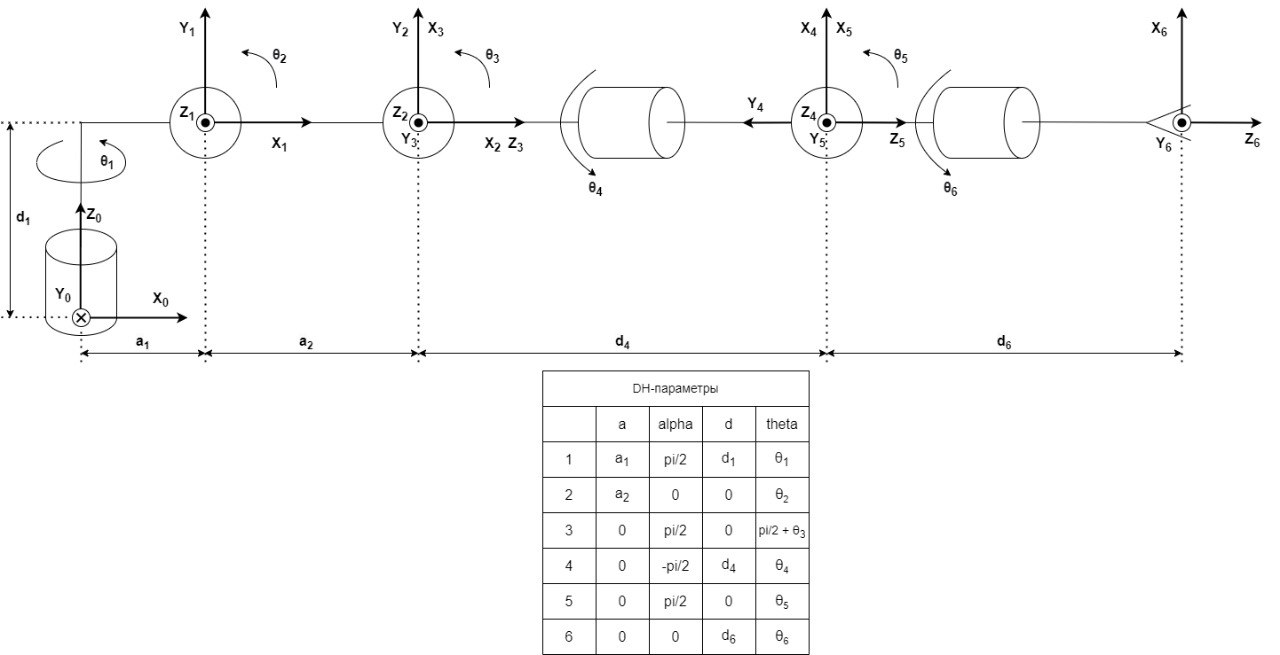

## Матрицы преобразования систем координат
  Матрицы $T_1...T_6$ содержат в себе информацию для ориентации в пространстве и для смещения системы координат.
  Список с углами theta сожержит в себе углы для поворота каждого из джойнтов. 
В данный момент мы уже должны знать углы $\theta_1, \; \theta_2, \; \theta_3$

In [52]:
theta = []
for i in range(6):
  theta.append(Symbol(f'theta_{i+1}'))
a1 = Symbol('a1')
a2 = Symbol('a2')
d1 = Symbol('d1')
d4 = Symbol('d4')
d6 = Symbol('d6')
T1 = [[cos(theta[0]), 0, sin(theta[0]), a1*cos(theta[0])],
      [sin(theta[0]), 0, -cos(theta[0]), a1*sin(theta[0])], 
      [0, 1, 0, d1],
      [0, 0, 0, 1]]
T2 = [[cos(theta[1]), -sin(theta[1]), 0, a2*cos(theta[1])],
      [sin(theta[1]), cos(theta[1]), 0, a2*sin(theta[1])],
      [0, 0, 1, 0],
      [0, 0, 0, 1]]
T3 = [[cos(theta[2]+pi/2), 0, sin(theta[2]+pi/2), 0],
      [sin(theta[2]+pi/2), 0, -cos(theta[2]+pi/2), 0], 
      [0, 1, 0, 0],
      [0, 0, 0, 1]]
T4 = [[cos(theta[3]), 0, -sin(theta[3]), 0],
      [sin(theta[3]), 0, cos(theta[3]), 0], 
      [0, -1, 0, d4],
      [0, 0, 0, 1]]
T5 = [[cos(theta[4]), 0, sin(theta[4]), 0],
      [sin(theta[4]), 0, -cos(theta[4]), 0], 
      [0, 1, 0, 0],
      [0, 0, 0, 1]]
T6 = [[cos(theta[5]), -sin(theta[5]), 0, 0],
      [sin(theta[5]), cos(theta[5]), 0, 0],
      [0, 0, 1, d6],
      [0, 0, 0, 1]]


Создадим матрицу поворота конечной системы координат. Данная матрица является входной, на основе ее значений считаются последнии три угла джойнтов, а также координаты сферического запястья (в основной программе эти переменные называются xc, yc, zc).

In [53]:
R = [[], [], []]
for i in range(3):
  for j in range(3):
    R[i].append(Symbol(f'r{i+1}{j+1}'))
R

[[r11, r12, r13], [r21, r22, r23], [r31, r32, r33]]

Находим матрицу преобразования координат $T_{03}$.

К данному моменту она содержит все известные переменные, потому что первые три угла были высчитаны на первом этапе.

$R^3_6 = (R^0_3)^T R$ [0]

In [54]:
T03 = np.dot(T1, T2).dot(T3)
R03 = T03[0:3, 0:3]
R03_T = np.transpose(R03) # Транспонированная матрица R_03
R03_T

array([[-sin(theta_2)*cos(theta_1)*cos(theta_3) - sin(theta_3)*cos(theta_1)*cos(theta_2),
        -sin(theta_1)*sin(theta_2)*cos(theta_3) - sin(theta_1)*sin(theta_3)*cos(theta_2),
        -sin(theta_2)*sin(theta_3) + cos(theta_2)*cos(theta_3)],
       [sin(theta_1), -cos(theta_1), 0],
       [-sin(theta_2)*sin(theta_3)*cos(theta_1) + cos(theta_1)*cos(theta_2)*cos(theta_3),
        -sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3),
        sin(theta_2)*cos(theta_3) + sin(theta_3)*cos(theta_2)]],
      dtype=object)

Далее найдем матрицу преобразования координат $T_{36}$

In [55]:
T36 = np.dot(T4, T5).dot(T6)
R36 = T36[0:3, 0:3]
R36[2, 2]

cos(theta_5)

\begin{equation*}
R_{36} =\\ = \left(\begin{array}{cccc}
-sin(\theta_4)*sin(\theta_6) + cos(\theta_4)*cos(\theta_5)*cos(\theta_6) & -sin(\theta_4)*cos(\theta_6) - sin(\theta_6)*cos(\theta_4)*cos(\theta_5) & sin(\theta_5)*cos(\theta_4)\\
sin(\theta_4)*cos(\theta_5)*cos(theta_6) + sin(\theta_6)*cos(\theta_4) & -sin(\theta_4)*sin(\theta_6)*cos(\theta_5) + cos(theta_4)*cos(\theta_6) & sin(\theta_4)*sin(\theta_5)\\
-sin(\theta_5)*cos(\theta_6) & sin(\theta_5)*sin(\theta_6) & cos(\theta_5)
\end{array}
\right)
\end{equation*}

Далее находим значение правой части уравнения [0]

In [56]:
R36_r = np.dot(R03_T, R)
R36_r[2, 2]

r13*(-sin(theta_2)*sin(theta_3)*cos(theta_1) + cos(theta_1)*cos(theta_2)*cos(theta_3)) + r23*(-sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3)) + r33*(sin(theta_2)*cos(theta_3) + sin(theta_3)*cos(theta_2))

Далее необходимо найти из данных уравнений углы $\theta_4, \; \theta_5, \; \theta_6$.

Для начала находим угол $\theta_5$, в матрице это член $R_{36}[3, 3]$ (в коде $R_{36}[2, 2]$, потому что отсчет столбцов и строк начинается с 0)

In [57]:
cos_theta_5 = simplify(R36_r[2, 2])

По формуле можно преобразовать данный арккосинус в atan2(), причем можно брать два решения:

$\theta_5 = atan2(\pm\sqrt{1 - cos^2({\theta_5})},\; cos(\theta_5))$
Причем нам необходимо взять вариант решения с минусом по той причине, что пятый джойнт двигается в диапазоне [-207.15, 1.5] (значение в будущем может меняться) град., то есть при решения ОЗК этот угол будет отрицаительным.

In [58]:
Theta_5 = atan2(-sympy.sqrt(1 - cos_theta_5**2), cos_theta_5)
[Theta_5]

[atan2(-sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2), r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))]

$\theta_5 = atan2(\pm \sqrt{1-(r13​cos(θ1​)cos(θ2​+θ3​)+r23​sin(θ1​)cos(θ2​+θ3​)+r33​sin(θ2​+θ3​))^2}, r13​cos(θ1​)cos(θ2​+θ3​)+r23​sin(θ1​)cos(θ2​+θ3​)+r33​sin(θ2​+θ3​))$ 

[1]

Выберем член $R_{36}$[2, 3] для того, чтобы найти угол $\theta_4$

In [59]:
R36[1, 2]

sin(theta_4)*sin(theta_5)

Далее нам необходимо в левой части уравнения [0] выяснить, чему будет равен член $R_{36}$[2, 3] ([1, 2] в коде), чтобы приравнять это к правой части R36_r[2, 3] ([1, 2] в коде).

In [60]:
R36_new_1_2 = R36[1, 2].subs(theta[4], Theta_5)
R36_new_1_2

-sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2)*sin(theta_4)

Подставим в синус $\theta_5$, чтобы можно было вычислить $\theta_4$ на основе ранее выведенного уранвения [1]

In [61]:
sin_theta_5 = sin(Theta_5)
sin_theta_5

-sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2)

In [62]:
R36_r[1, 2]

r13*sin(theta_1) - r23*cos(theta_1)

In [63]:
simplify(R36_r[1, 2]-R36[1, 2])

r13*sin(theta_1) - r23*cos(theta_1) - sin(theta_4)*sin(theta_5)

Находим из уравнения выше $\sin(\theta_4)$

In [64]:
sin_theta_4 = R36_r[1, 2]/sin_theta_5
sin_theta_4

-(r13*sin(theta_1) - r23*cos(theta_1))/sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2)

Для $\theta_4$ берем первое решение, выражение выглядит следующим образом:

In [65]:
Theta_4 = atan2(sin_theta_4, sqrt(1-sin_theta_4**2))
[Theta_4]

[atan2(-(r13*sin(theta_1) - r23*cos(theta_1))/sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2), sqrt(1 - (r13*sin(theta_1) - r23*cos(theta_1))**2/(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2)))]

Далее найдем угол $\theta_6$ для последнего джойнта.

$R_{36} [3, 2]$

In [66]:
R36[2, 1]

sin(theta_5)*sin(theta_6)

In [67]:
[R36_r[2, 1]]

[r12*(-sin(theta_2)*sin(theta_3)*cos(theta_1) + cos(theta_1)*cos(theta_2)*cos(theta_3)) + r22*(-sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3)) + r32*(sin(theta_2)*cos(theta_3) + sin(theta_3)*cos(theta_2))]

$sin(\theta_5​)sin(\theta_6​) = r_{12}*(-sin(\theta_2)*sin(\theta_3)*cos(\theta_1) + cos(\theta_1)*cos(\theta_2)*cos(\theta_3)) + r_{22}*(-sin(\theta_1)*sin(\theta_2)*sin(\theta_3) + sin(\theta_1)*cos(\theta_2)*cos(\theta_3)) + r_{32}*(sin(\theta_2)*cos(\theta_3) + sin(\theta_3)*cos(\theta_2))$

In [68]:
sin_theta_6 = R36_r[2, 1]/sin_theta_5
sin_theta_6

-(r12*(-sin(theta_2)*sin(theta_3)*cos(theta_1) + cos(theta_1)*cos(theta_2)*cos(theta_3)) + r22*(-sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3)) + r32*(sin(theta_2)*cos(theta_3) + sin(theta_3)*cos(theta_2)))/sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2)

Берем второе решение со знаком минус

In [69]:
Theta_6 = atan2(-sin_theta_6, sqrt(1-sin_theta_6**2))
Theta_6

atan2((r12*(-sin(theta_2)*sin(theta_3)*cos(theta_1) + cos(theta_1)*cos(theta_2)*cos(theta_3)) + r22*(-sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3)) + r32*(sin(theta_2)*cos(theta_3) + sin(theta_3)*cos(theta_2)))/sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2), sqrt(1 - (r12*(-sin(theta_2)*sin(theta_3)*cos(theta_1) + cos(theta_1)*cos(theta_2)*cos(theta_3)) + r22*(-sin(theta_1)*sin(theta_2)*sin(theta_3) + sin(theta_1)*cos(theta_2)*cos(theta_3)) + r32*(sin(theta_2)*cos(theta_3) + sin(theta_3)*cos(theta_2)))**2/(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2)))

Упростим выражение для последнего угла: 

In [70]:
Theta_6 = simplify(Theta_6)

In [71]:
Theta_6

atan2((r12*cos(theta_1)*cos(theta_2 + theta_3) + r22*sin(theta_1)*cos(theta_2 + theta_3) + r32*sin(theta_2 + theta_3))/sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2), sqrt(((r12*cos(theta_1)*cos(theta_2 + theta_3) + r22*sin(theta_1)*cos(theta_2 + theta_3) + r32*sin(theta_2 + theta_3))**2 + (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2 - 1)/((r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2 - 1)))

In [72]:
[Theta_6]

[atan2((r12*cos(theta_1)*cos(theta_2 + theta_3) + r22*sin(theta_1)*cos(theta_2 + theta_3) + r32*sin(theta_2 + theta_3))/sqrt(1 - (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2), sqrt(((r12*cos(theta_1)*cos(theta_2 + theta_3) + r22*sin(theta_1)*cos(theta_2 + theta_3) + r32*sin(theta_2 + theta_3))**2 + (r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2 - 1)/((r13*cos(theta_1)*cos(theta_2 + theta_3) + r23*sin(theta_1)*cos(theta_2 + theta_3) + r33*sin(theta_2 + theta_3))**2 - 1)))]